# <a href="https://thetahat.ru/courses/ad" target="_top">Введение в анализ данных</a>

## Метод главных компонент (Principal Component Analysis, PCA)


Метод главных компонент это статистический метод, который используется для уменьшения размерности данных, сохраняя при этом как можно больше информации.

Основная идея PCA заключается в том, чтобы преобразовать исходные переменные в новый набор некоррелированных переменных, которые называются *главными компонентами*. Главные компоненты создаются так, чтобы первая компонента объясняла наибольшую долю дисперсии исходных данных, вторая — следующую по величине долю и так далее. Сжатое представление данных в виде главных компонент может быть использовано для визуализации многомерных данных, для кластеризации, в качестве входных данных для других методов машинного обучения или для других аналитических целей. Подробнее теорию метода можно посмотреть в [презентации](https://thetahat.ru/files/ad/main/7/lec7.pdf) с лекции. Применение PCA в задаче кластеризации можно посмотреть в <a href="https://thetahat.ru/courses/ad/main/7/clustering" target="_top">следующем ноутбуке</a>.

In [ ]:
import os
from typing import List, Optional, Tuple
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.auto import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import cv2
import imageio
from IPython.display import Image

RANDOM_STATE = 42
sns.set_theme(style="darkgrid", palette="Set2")

> #### Реализация PCA из sklearn
> 
> <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA" target="_top">`sklearn.decomposition.PCA`</a>`(n_components=None)`
> 
> Самый важный параметр: 
> * `n_components` &mdash; размерность сжатого пространства, иными словами количество главных компоненты.
> 
> Методы класса:
> * `fit(X)` &mdash; обучиться на данных `X`;
> * `transform(X_new)` &mdash; вернуть сжатое представление `X_new` для обученной ранее модели;
> * `fit_transforn(X)` &mdash; обучиться на данных `X` и вернуть сжатое представление `X`;
> * `inverse_transform(Y)` &mdash; восстановить сжатые данные `Y` в исходное пространство.
> 
> Атрибуты класса:
> 
> * `components_` &mdash; главные компоненты в порядке убывания доли объясненной дисперсии (собственных чисел), размер `(n_components, n_features)`;
> * `explained_variance_` &mdash; дисперсия вдоль главных компонент, равны собственным числам, размер `(n_components,)`;
> * `explained_variance_ratio_` &mdash; доля дисперсии, объясняемая каждой компонентой, размер `(n_components,)`;
> * `mean_` &mdash; среднее по данным, размер `(n_features,)`.


### 1. Простой пример

Вначале рассмотрим самый простой пример: отобразим двумерные данные в одномерное пространство, а затем применим обратное преобразование

Сгенерируем 100 точек в двумерном пространстве и визуализируем их

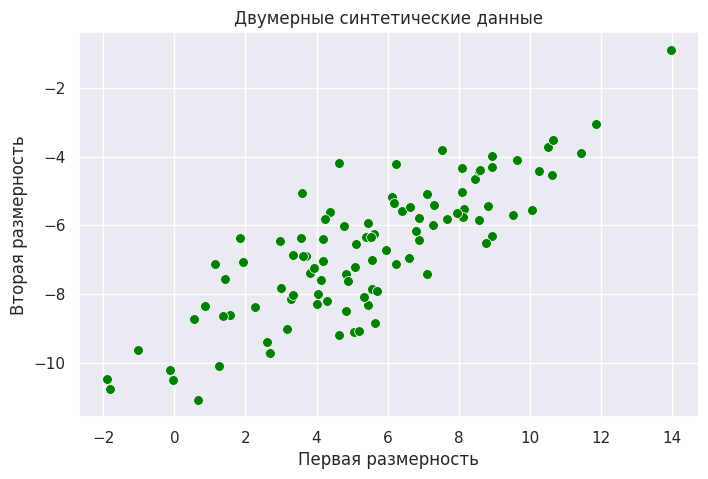

In [2]:
sample_size = 100  # Размер выборки
sample = sps.multivariate_normal(mean=[5, -7], cov=[[13, 7], [7, 5]]).rvs(
    sample_size, random_state=RANDOM_STATE
)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=sample[:, 0], y=sample[:, 1], s=50, c="g")
plt.title("Двумерные синтетические данные")
plt.xlabel("Первая размерность")
plt.ylabel("Вторая размерность")
plt.show()

Применим PCA для отображения в одномерное пространство (`n_components=1`)

Направления главных компонент в исходном пространстве (одной компоненты): [[0.87  0.494]]
Среднее по данным: [ 5.396 -6.732] == [ 5.396 -6.732]
Размерность проекции: (100, 1)


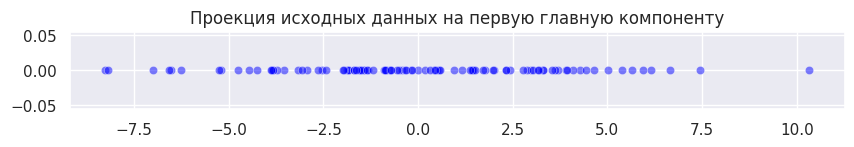

In [3]:
# Обучаем и тут же применяем PCA
pca = PCA(n_components=1)
sample_projection = pca.fit_transform(sample)

print(
    f"Направления главных компонент в исходном пространстве (одной компоненты): {pca.components_.round(3)}"
)
print(f"Среднее по данным: {pca.mean_.round(3)} == {sample.mean(axis=0).round(3)}")
print(f"Размерность проекции: {sample_projection.shape}")

# Визуализируем на числовой прямой проекцию после применения PCA
plt.figure(figsize=(10, 1))
sns.scatterplot(x=sample_projection[:, 0], y=0, c="b", alpha=0.5)
plt.title("Проекция исходных данных на первую главную компоненту")
plt.show()

Теперь применим обратное преобразование и визуализируем вместе с исходными точками

In [4]:
sample_reprojection = pca.inverse_transform(sample_projection)
print(f"Размерность репроекции в исходное пространство: {sample_reprojection.shape}")

Размерность репроекции в исходное пространство: (100, 2)


Визуализируем результат вместе с исходными точками

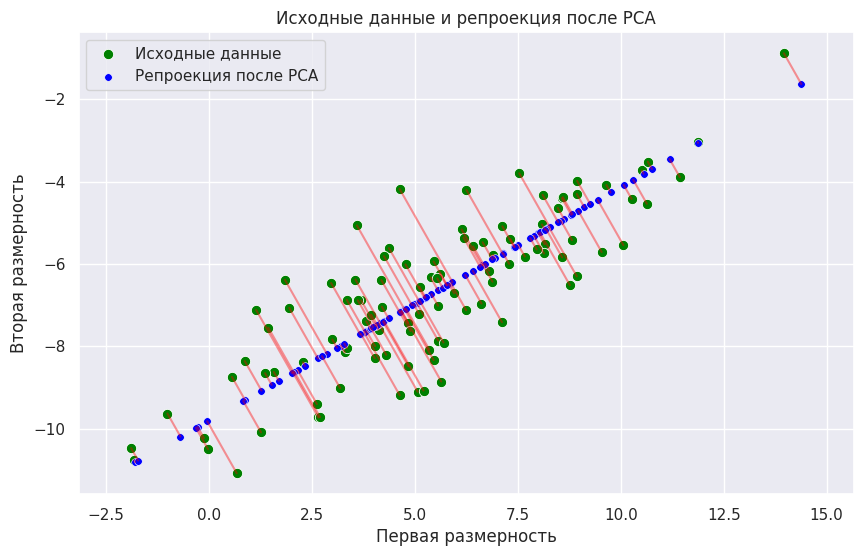

In [5]:
plt.figure(figsize=(10, 6))

# Рисуем отрезки, соединяющие исходную точку и ее образ
for point, reproj in zip(sample, sample_reprojection):
    plt.plot([point[0], reproj[0]], [point[1], reproj[1]], c="red", alpha=0.4)

# Рисуем исходные точки
sns.scatterplot(
    x=sample[:, 0], y=sample[:, 1], s=55, c="green", label="Исходные данные"
)
# Рисуем восстановленные точки
sns.scatterplot(
    x=sample_reprojection[:, 0],
    y=sample_reprojection[:, 1],
    s=30,
    c="blue",
    label="Репроекция после PCA",
)

plt.axis("equal")  # Включаем одинаковый масштаб по осям, чтобы увидеть прямой угол
plt.title("Исходные данные и репроекция после PCA")
plt.xlabel("Первая размерность")
plt.ylabel("Вторая размерность")
plt.show()

Можно заметить несколько интересных моментов:
- Восстановленные данные лежат на одной прямой. Это объясняется линейностью обратного преобразования, а прямые (в частности любые одномерные данные) всегда переходят в прямые при линейном отображении.
- Отрезки соединяющие исходные точки и их восстановленные образы перпендикулярны прямой с образами. Так происходит, потому что PCA стремится максимизировать дисперсию вдоль первой главной компоненты, а значит минимизировать дисперсию (расстояние между точкой и образом) в нормальном направлении к этой прямой.

### 2. PCA для сжатия датасетов изображений лиц

Изображения можно рассматривать как большие многомерные вектора. Попробуем применить к ним PCA.


Для начала загрузим <a href="https://thetahat.ru/files/ad/main/7/train_faces.npy" target="_top">датасет</a> фотографий человеческих лиц. В нем $280$ изображений, каждое размера $32 \times 32$ пикселя, то есть размерность одного вектора $1024$.

Размерность faces: (280, 1024)


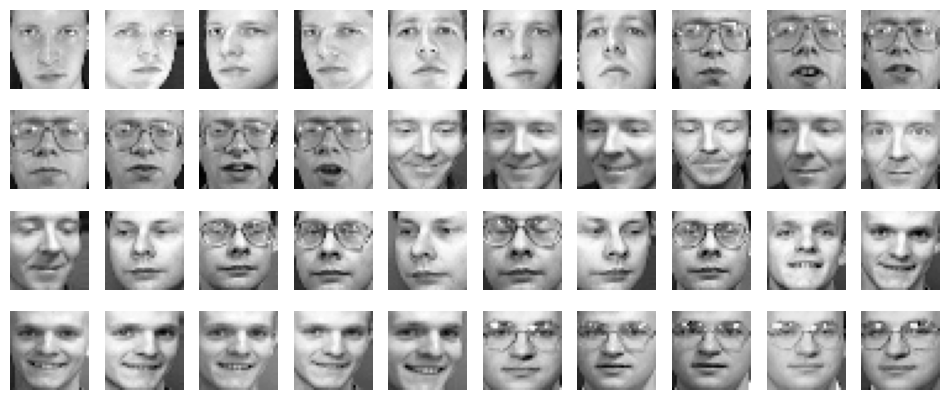

In [6]:
faces = np.loadtxt("data/train_faces.npy")
print(f"Размерность faces: {faces.shape}")

# Визуализируем несколько примеров из датасета
plt.figure(figsize=(12, 5))
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.imshow(faces[i].reshape((32, 32)), cmap="gray")
    plt.axis("off")

Сделаем проекцию из исходного 1024-мерного пространства в 50-мерное с помощью PCA. Таким образом все изображения разложатся в сумму среднего и линейной комбинации из 50-ти изображений, являющихся первыми 50-тью главными компонентами.

In [7]:
pca = PCA(n_components=50)
faces_projection = pca.fit_transform(faces)
print(f"Размерность проекции: {faces_projection.shape}")

Размерность проекции: (280, 50)


Напишем различные функции для визуализации

In [8]:
def plot_projection_scatter(
    images_projection: np.ndarray,
    figsize: Tuple[int, int] = (6, 6),
    cmap: str = "summer",
    xlabel: str = "Первая главная компонента",
    ylabel: str = "Вторая главная компонента",
) -> None:
    """
    Визуализирует проекции изображений в виде scatter plot с цветовой кодировкой.

    Параметры:
        images_projection: Массив проекций и значений цвета формы (n_samples, 3)
                          [:, 0] - координата X, [:, 1] - координата Y, [:, 2] - цвет
        figsize: Размер выходной фигуры
        cmap: Используемая цветовая карта
        xlabel: Подпись оси X
        ylabel: Подпись оси Y
    """
    plt.figure(figsize=figsize)
    plt.scatter(
        images_projection[:, 0],
        images_projection[:, 1],
        c=images_projection[:, 2],
        cmap=cmap,
        alpha=0.7,
    )
    plt.axis("equal")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


def rescale_image(image: np.ndarray) -> np.ndarray:
    """
    Нормализует массив к диапазону [0, 1] через линейное преобразование.

    Параметры:
        image: Входной массив произвольной формы

    Возвращает:
        Нормализованный массив той же формы, где min=0, max=1
    """
    return (image - image.min()) / (image.max() - image.min())


def plot_projected_images(
    images: np.ndarray,
    images_projection: np.ndarray,
    shape: Tuple[int, int] = (32, 32),
    figsize: Tuple[int, int] = (12, 8),
    zoom: float = 0.5,
    cmap: Optional[str] = None,
    n_images: Optional[int] = None,
    random_state: Optional[int] = None,
) -> None:
    """
    Визуализирует 2D проекции изображений с миниатюрами в точках проекции.

    Параметры:
        images: Массив изображений формы (n_samples, height*width)
        images_projection: Координаты проекций формы (n_samples, 2)
        shape: Оригинальные размеры изображений (height, width)
        figsize: Размер выходной фигуры
        zoom: Масштаб миниатюр (0-1)
        cmap: Цветовая карта для изображений
        n_images: Количество случайных изображений для отображения (None - все)
        random_state: Seed для воспроизводимости выборки
    """
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(figsize=figsize)

        # Выбираем индексы изображений для отображения
        if n_images is not None:
            rng = np.random.RandomState(random_state)
            n_images = min(n_images, len(images_projection))
            indices = rng.choice(len(images_projection), size=n_images, replace=False)
        else:
            indices = range(len(images_projection))

        for i in indices:
            # Формируем изображение
            img = images[i].reshape(shape)
            imagebox = OffsetImage(img, zoom=zoom, cmap=cmap)

            # Создаем аннотацию с изображением
            ab = AnnotationBbox(
                imagebox,
                (images_projection[i, 0], images_projection[i, 1]),
                frameon=False,
            )
            ax.add_artist(ab)

        # Устанавливаем границы осей
        ax.set_xlim(np.min(images_projection[:, 0]), np.max(images_projection[:, 0]))
        ax.set_ylim(np.min(images_projection[:, 1]), np.max(images_projection[:, 1]))
        ax.set_xlabel("Первая главная компонента")
        ax.set_ylabel("Вторая главная компонента")

        plt.tight_layout()
        plt.show()

Отобразим данные в проекции на первые две главные компоненты, также цветом отобразим третью главную компоненту

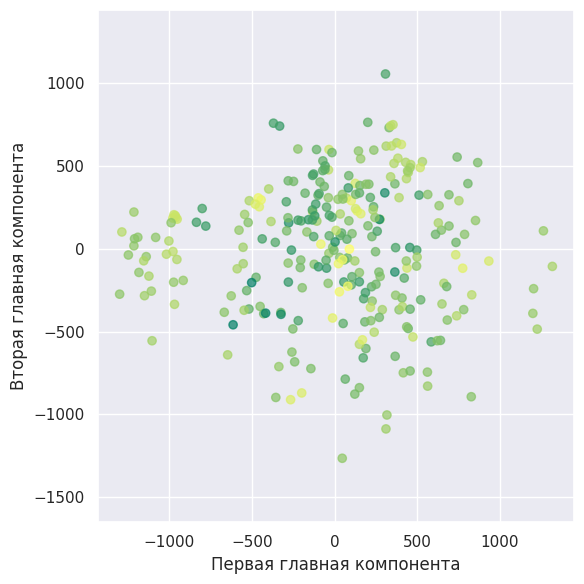

In [9]:
plot_projection_scatter(faces_projection)

Тот же самый график, но вместо точек визуализируем сами исходные объекты

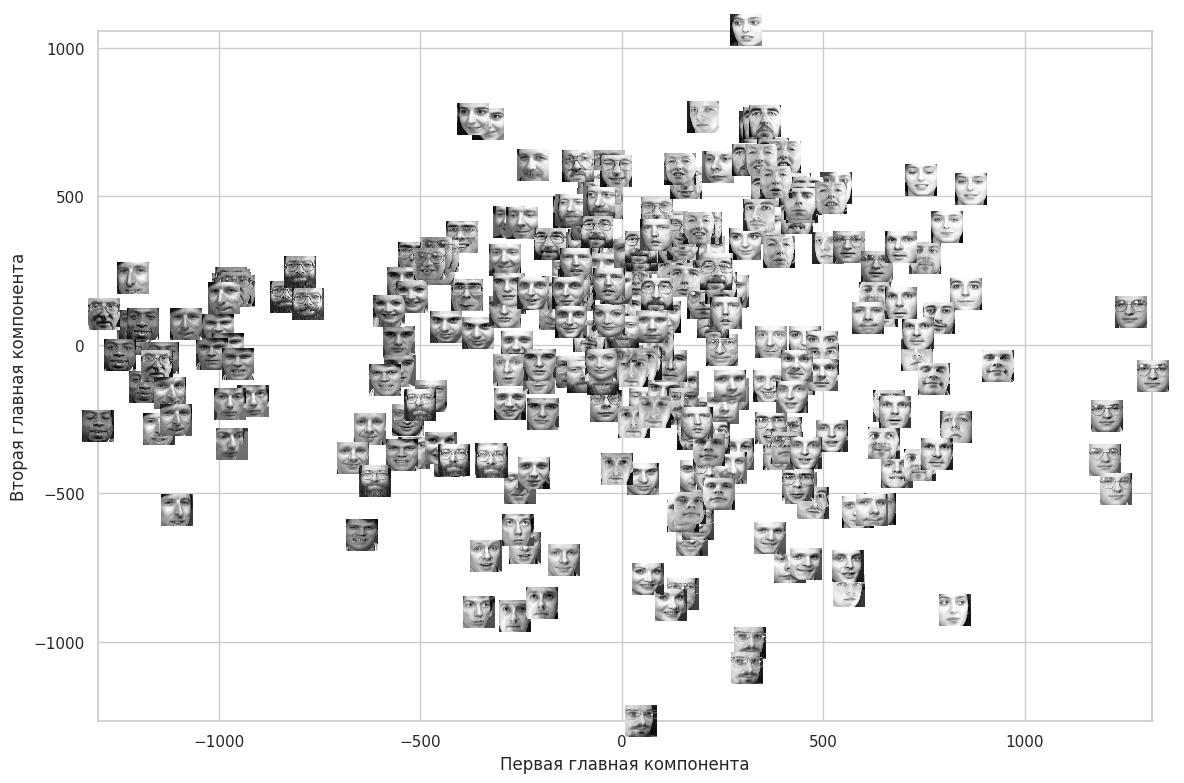

In [10]:
plot_projected_images(faces, faces_projection, shape=(32, 32), zoom=0.7, cmap="gray")

Визуализируем главные компоненты (по сути базисы, на которые разложилось каждое изображение):

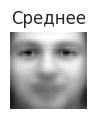

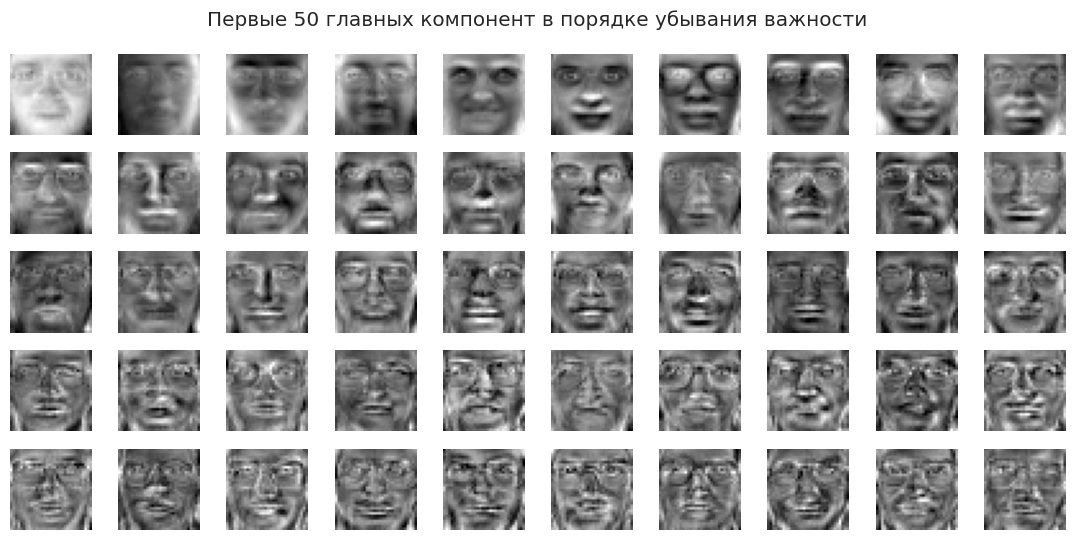

In [11]:
def visualize_main_components(
    pca: PCA,
    num_components: int = 50,
    image_shape: Tuple[int, ...] = (32, 32),
) -> None:
    """
    Визуализирует главные компоненты и среднее значение после PCA преобразования.

    Параметры:
        pca: Обученная модель PCA из sklearn.decomposition
        num_components: Количество главных компонент для визуализации (по умолчанию 50)
        image_shape: Размерность исходных изображений:
                    - (height, width) для grayscale
                    - (height, width, channels) для цветных изображений
    """

    cmap = "gray" if image_shape[-1] != 3 else None
    n_cols = 10
    n_rows = (num_components + n_cols - 1) // n_cols

    # Визуализируем среднее
    plt.figure(figsize=(1, 1))
    plt.imshow(rescale_image(pca.mean_.reshape(image_shape)), cmap=cmap)
    plt.title("Среднее")
    plt.axis("off")
    plt.show()

    # Визуализируем главные компоненты
    plt.figure(figsize=(n_cols * 1.1, n_rows * 1.1))
    plt.suptitle(
        f"Первые {num_components} главных компонент в порядке убывания важности"
    )
    for i in range(num_components):
        plt.subplot(n_rows, n_cols, i + 1)
        # Так как значения каждого пикселя изображения должны быть на отрезке [0, 1],
        # а главные компоненты могут не удовлетворять этому условию, отнормируем их
        plt.imshow(rescale_image(pca.components_[i].reshape(image_shape)), cmap=cmap)
        plt.axis("off")

    plt.tight_layout()


visualize_main_components(pca, num_components=50)

Как видно, на всех основных элементах прослеживаются очертания лиц. При этом если в первых элементах черты лица размыты и границы нечеткие, то в последних, наоборот, выделяются различные детали. То есть сначала видны общие черты лица: контур, поворот головы, глаза, а затем более мелкие детали: форма губ, бровей, очки и так далее.

Теперь для нескольких примеров изображений посмотрим с каким весом в них входит каждая главная компонента. Ниже 
* в первой колонке изображено исходное лицо, 
* во второй его приближение (проекция на первые 10 главных компонент),
* в третьей колонке среднее лицо, 
* в следующих 10 колонках первые 10 главных компонент, над которыми указаны коэффициенты, с которыми они входят в приближаемое лицо.

Стоит отметить, что все компоненты нормированы, однако при отрисовке они растягиваются до диапазона $[0, 255]$. Поэтому коэффициенты относятся не к изображениям компонент, а к самим нормированным компонентам.

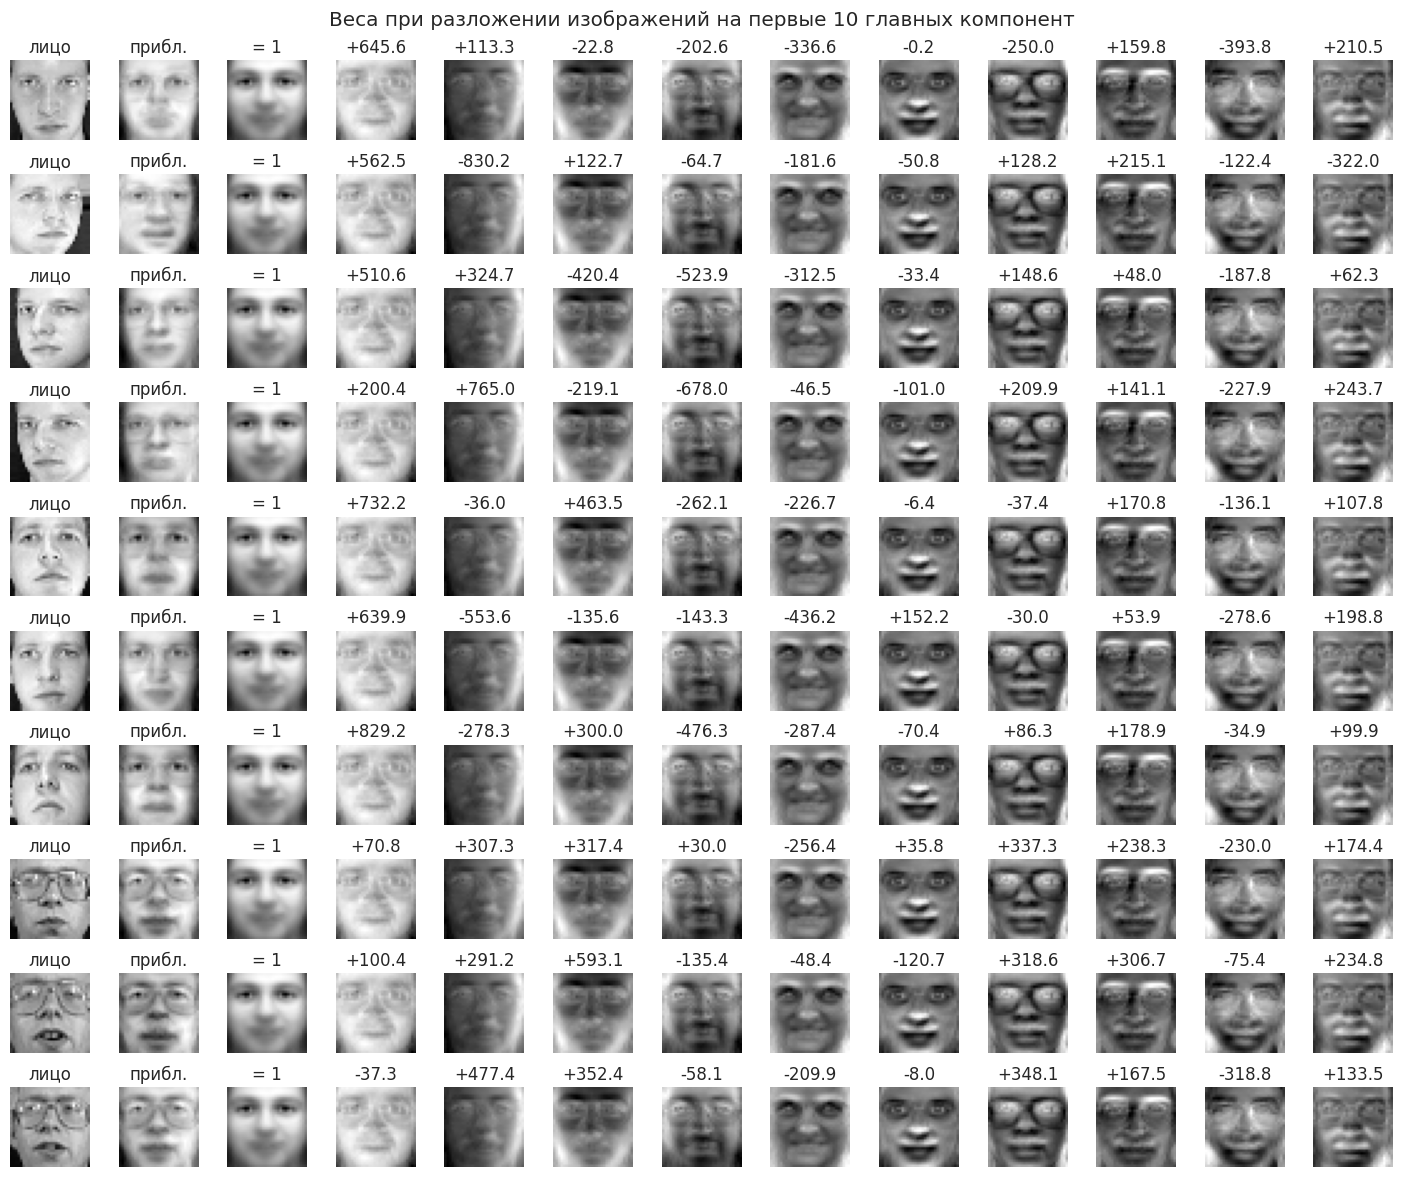

In [12]:
def visualize_projection_images(
    images: np.ndarray,
    n_components: int,
    num_images: int = 5,
    image_shape: Tuple[int, ...] = (32, 32),
) -> None:
    """
    Визуализирует разложение изображений на главные компоненты и их реконструкцию.

    Для каждого изображения показывает:
    1. Оригинальное изображение
    2. Реконструированное изображение
    3. Среднее значение
    4. Вклад каждой главной компоненты с коэффициентами

    Параметры:
        images: Массив изображений формы (n_samples, n_features)
        n_components: Количество используемых главных компонент
        num_images: Количество изображений для визуализации (по умолчанию 5)
        image_shape: Размерность исходных изображений:
                    - (height, width) для grayscale
                    - (height, width, channels) для цветных изображений
    """

    pca = PCA(n_components=n_components)
    projection = pca.fit_transform(images)
    reprojection = pca.inverse_transform(projection)

    cmap = "gray" if image_shape[-1] != 3 else None
    num_columns = 3 + n_components

    plt.figure(figsize=(1.1 * num_columns, 1.2 * num_images))
    plt.suptitle(
        f"Веса при разложении изображений на первые {n_components} главных компонент"
    )

    for image_index in range(num_images):
        # Исходное изображение
        plt.subplot(num_images, num_columns, image_index * num_columns + 1)
        plt.imshow(images[image_index].reshape(image_shape), cmap=cmap)
        plt.title("лицо")
        plt.axis("off")

        # Репроекция
        plt.subplot(num_images, num_columns, image_index * num_columns + 2)
        plt.imshow(
            np.clip(reprojection[image_index].reshape(image_shape) / 255, 0, 1),
            cmap=cmap,
        )
        plt.title("прибл.")
        plt.axis("off")

        # Среднее
        plt.subplot(num_images, num_columns, image_index * num_columns + 3)
        plt.imshow(np.clip(pca.mean_.reshape(image_shape) / 255, 0, 1), cmap=cmap)
        plt.title("= 1")
        plt.axis("off")

        # Главные компоненты
        for component_idx in range(n_components):
            plt.subplot(
                num_images, num_columns, image_index * num_columns + 4 + component_idx
            )
            plt.imshow(
                rescale_image(pca.components_[component_idx].reshape(image_shape)),
                cmap=cmap,
            )

            coef = projection[image_index, component_idx]
            sign = "+" if coef >= 0 else ""
            plt.title(f"{sign}{coef:.1f}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()


visualize_projection_images(faces, n_components=10, num_images=10, image_shape=(32, 32))


Проведем эксперимент: переберем несколько значений `n_components` (количество главных компонент), для каждого обучим PCA, сделаем последовательно прямое и обратное преобразования, а затем визуально сравним полученные изображения с исходным.

100%|█████████████████████████████████████████████| 9/9 [00:03<00:00,  2.29it/s]


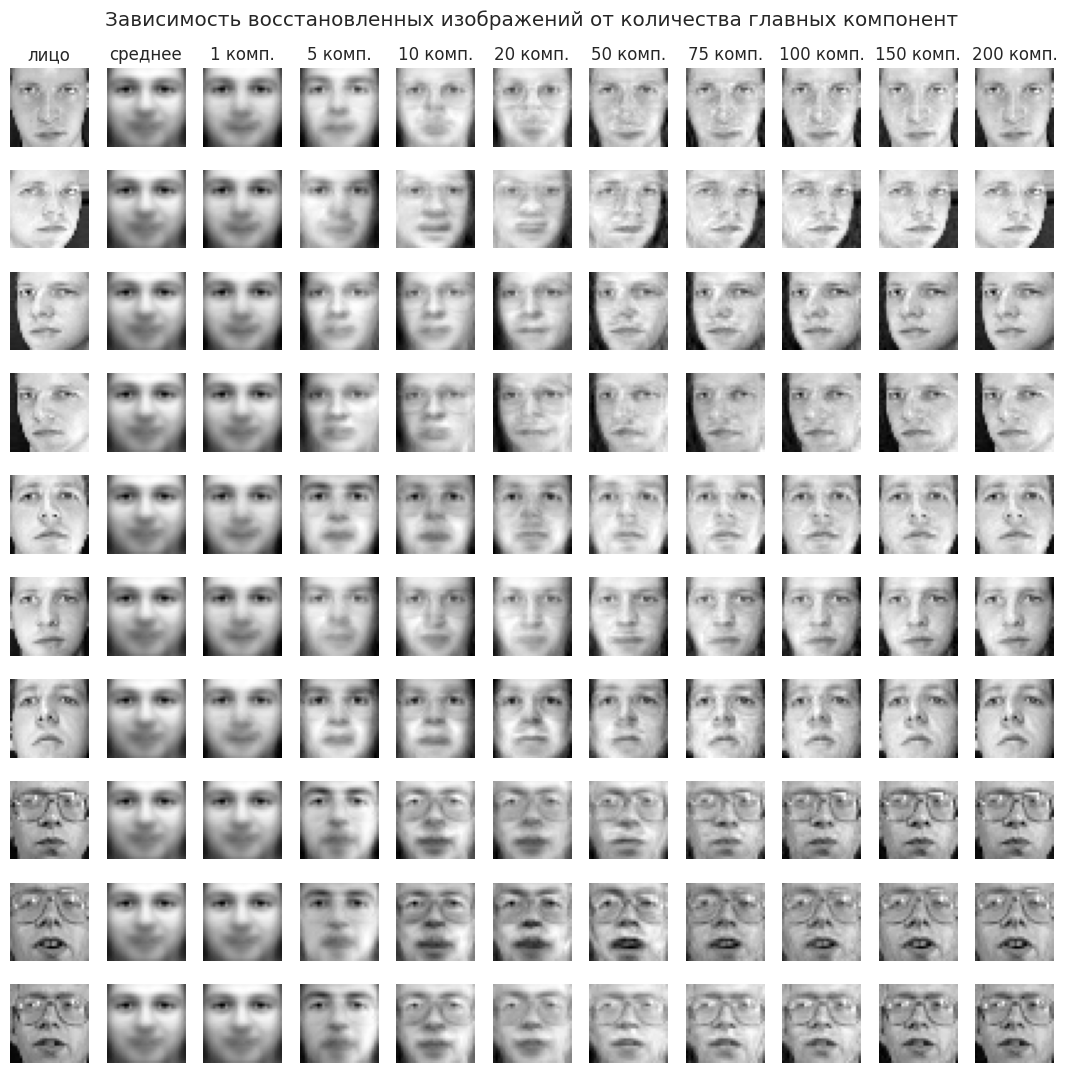

In [13]:
def visualize_decompress_images(
    images: np.ndarray,
    n_components_grid: List[int],
    num_images: int = 5,
    image_shape: Tuple[int, ...] = (32, 32),
) -> Dict[int, np.ndarray]:
    """
    Визуализирует качество восстановления изображений при разном числе главных компонент.

    Для каждого изображения показывает:
    1. Оригинальное изображение
    2. Среднее значение по датасету
    3. Восстановленные изображения для каждого количества компонент из n_components_grid

    Параметры:
        images: Массив изображений формы (n_samples, n_features)
        n_components_grid: Список количеств главных компонент для сравнения
        num_images: Количество изображений для визуализации (по умолчанию 5)
        image_shape: Размерность исходных изображений:
                    - (height, width) для grayscale
                    - (height, width, channels) для цветных изображений

    Возвращает:
        Словарь с восстановленными изображениями, где ключи - количества компонент,
        значения - массивы восстановленных изображений формы (n_samples, n_features)
    """

    reprojections = {}

    # Применяем PCA-проекцию и делаем восстановление
    for n_components in tqdm(n_components_grid):
        pca = PCA(n_components=n_components)
        projection = pca.fit_transform(images)
        reprojections[n_components] = pca.inverse_transform(projection)

    num_columns = 2 + len(n_components_grid)

    cmap = "gray" if image_shape[-1] != 3 else None
    plt.figure(figsize=(1.2 * len(n_components_grid), 1.1 * num_images))
    plt.suptitle(
        "Зависимость восстановленных изображений от количества главных компонент"
    )

    for image_index in range(num_images):

        # Исходное изображение
        plt.subplot(num_images, num_columns, image_index * num_columns + 1)
        plt.imshow(images[image_index].reshape(image_shape), cmap=cmap)
        if image_index == 0:
            plt.title("лицо")
        plt.axis("off")

        # Среднее
        plt.subplot(num_images, num_columns, image_index * num_columns + 2)
        plt.imshow(np.clip(pca.mean_.reshape(image_shape) / 255, 0, 1), cmap=cmap)
        if image_index == 0:
            plt.title("среднее")
        plt.axis("off")

        # Восстановленные изображения в зависимости от количества компоненты
        for col, n_components in enumerate(n_components_grid):
            plt.subplot(num_images, num_columns, image_index * num_columns + 3 + col)
            reproj = reprojections[n_components][image_index]
            plt.imshow(np.clip(reproj.reshape(image_shape) / 255, 0, 1), cmap=cmap)
            if image_index == 0:
                plt.title(f"{n_components} комп.")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

    return reprojections


faces_reprojections = visualize_decompress_images(
    faces,
    n_components_grid=[1, 5, 10, 20, 50, 75, 100, 150, 200],
    num_images=10,
    image_shape=(32, 32),
)

Можем заметить, что чем больше главных компонент мы задействуем, тем более детализированным становится изображение. Если использовать всего одну компоненту, можно воссоздать лишь общий контур человеческого лица. Если задействовать пять компонент, то станут видны некоторые особенности лица, например, поворот. Если использовать десять компонент, то можно различить формы глаз. А если использовать пятьдесят компонент, то уже можно увидеть очки.

### 3. PCA для сжатия датасетов изображений котиков


Как видно уже для 150 главных компонент разница между оригиналом и восстановленным изображением визуально почти незаметна.

Однако черно-белые маленькие изображения уж слишком игрушечный пример. Посмотрим на более интересный датасет котиков. В нем более $15\:000$ цветных фотографий размером $64 \times 64$, то есть им соответствует вектор размера $3 \cdot 64 \cdot 64 = 12\:288$.

Загрузим <a href="https://thetahat.ru/files/ad/main/7/cats.zip" target="_top">датасет</a> и посмотрим несколько примеров.

Размерность cats: (15747, 12288)


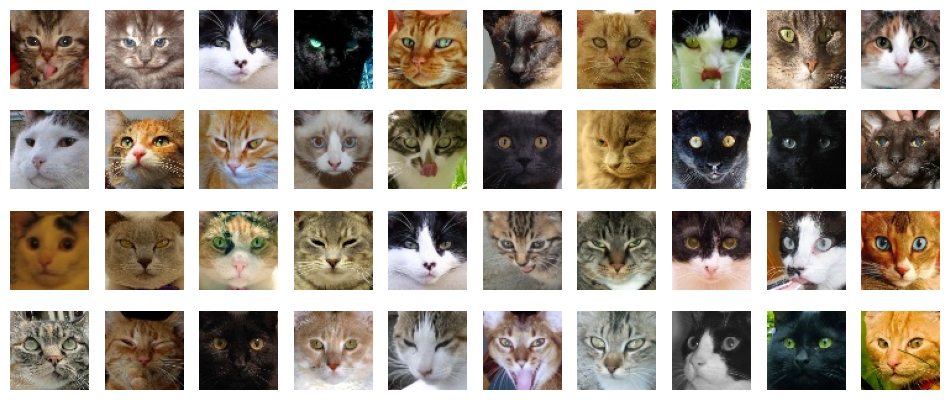

In [14]:
cats_path = "data/cats"
cats = []

for filename in os.listdir(cats_path):
    cats.append(plt.imread(os.path.join(cats_path, filename)))

cats = np.stack(cats).reshape(-1, 64 * 64 * 3)
print(f"Размерность cats: {cats.shape}")

# Визуализируем примеры
plt.figure(figsize=(12, 5))
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.imshow(cats[i].reshape(64, 64, 3))
    plt.axis("off")

Также как и ранее посмотрим на изображения, соответствующие первым 70 главным компонентам

In [15]:
pca = PCA(n_components=100)
cats_projection = pca.fit_transform(cats.astype(np.float32))
print(f"Размерность проекции: {cats_projection.shape}")

Размерность проекции: (15747, 100)


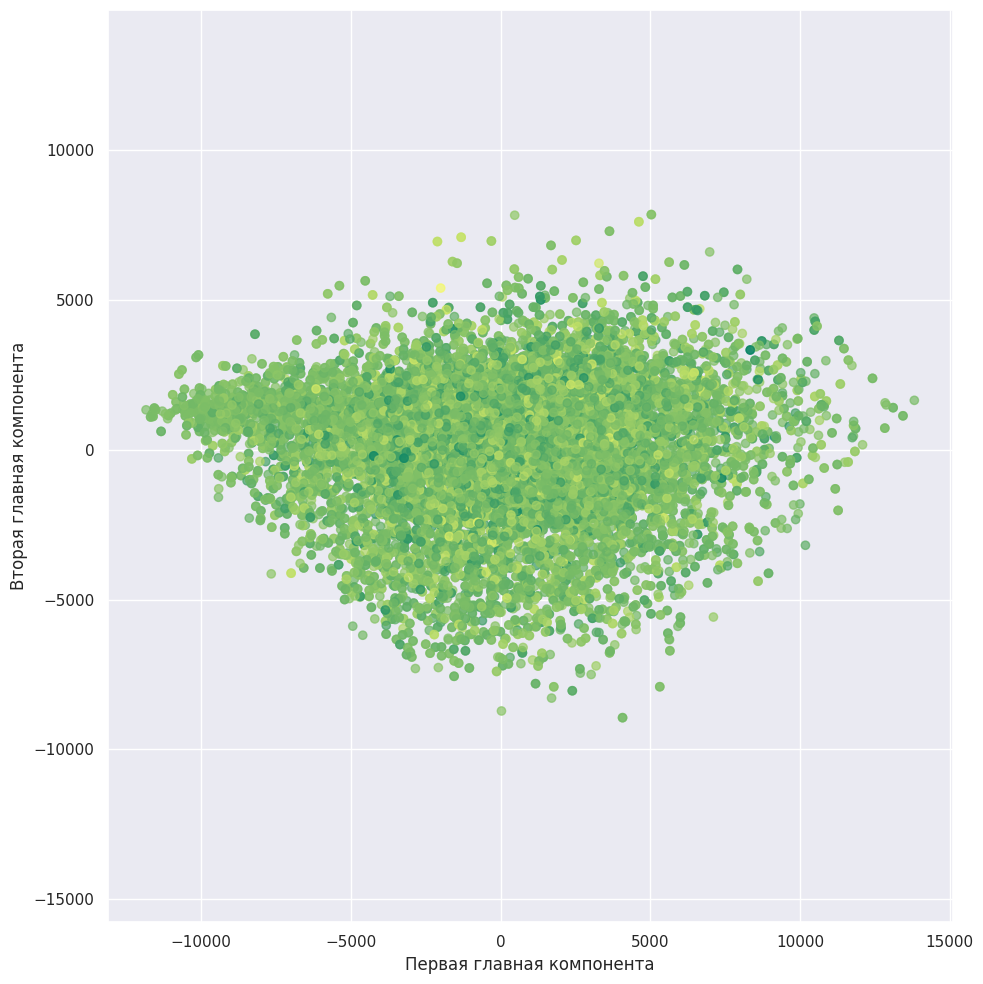

In [16]:
plot_projection_scatter(cats_projection, figsize=(10, 10))

Тот же самый график, но вместо точек визуализируем сами исходные изображения

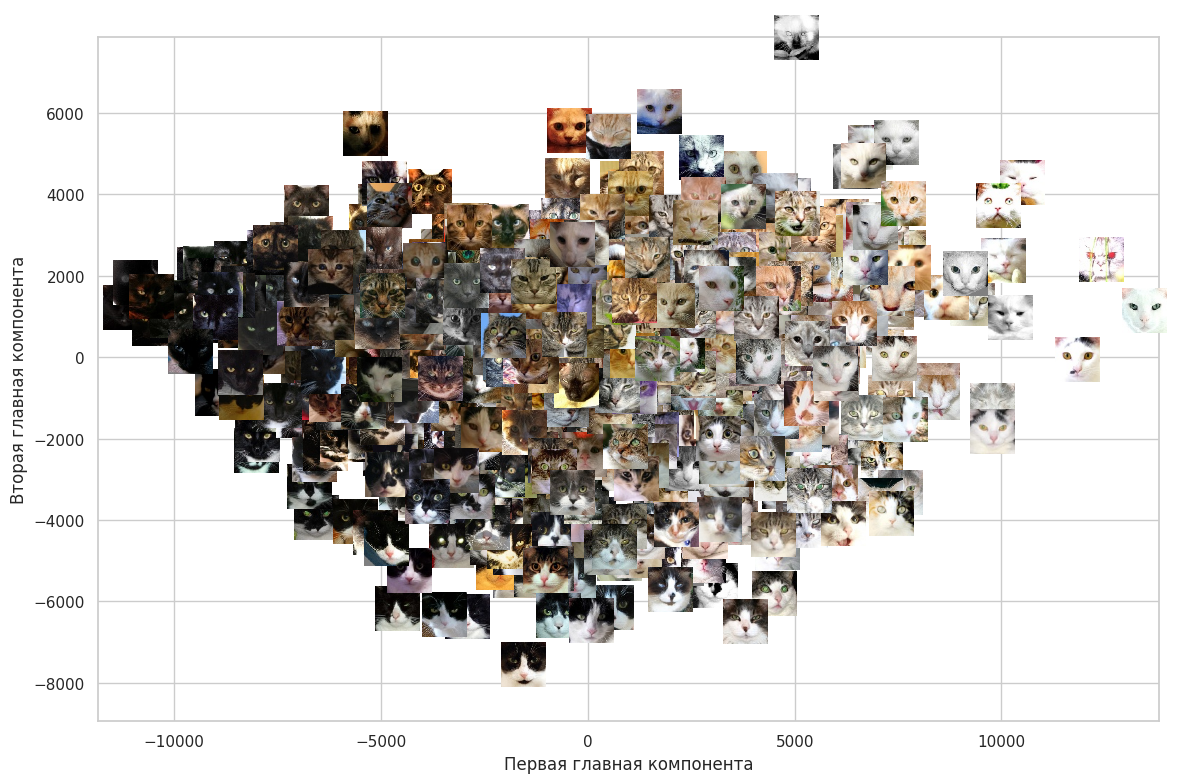

In [17]:
plot_projected_images(cats, cats_projection, shape=(64, 64, 3), zoom=0.5, n_images=1000)

Отобразим также первые 70 главных компонент

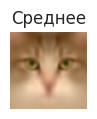

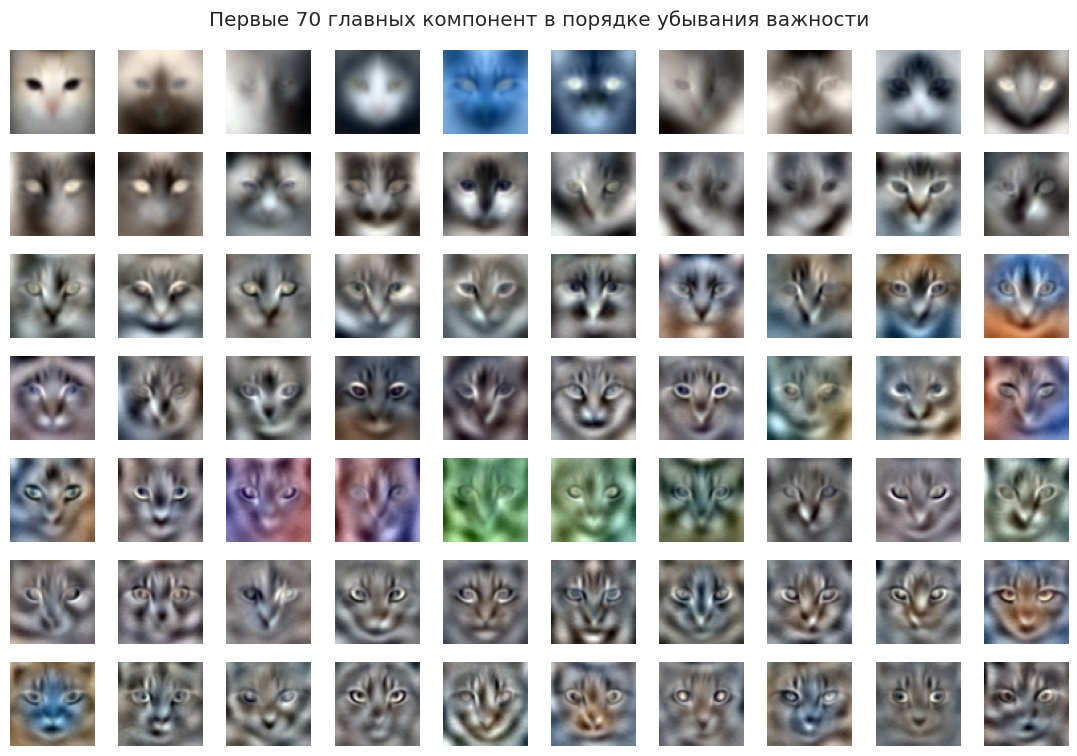

In [18]:
visualize_main_components(pca, num_components=70, image_shape=(64, 64, 3))

Как и в случае с лицами, на первом этапе мы видим размытые очертания, которые формируют общую форму кошачьей мордочки, повороты головы и общие черты глаз. Затем появляются более детальные изображения, включая цвет шерсти, пятнышки, усы и другие детали.

Теперь посмотрим с какими коэффициентами входят первые 10 главных компонент в изображение

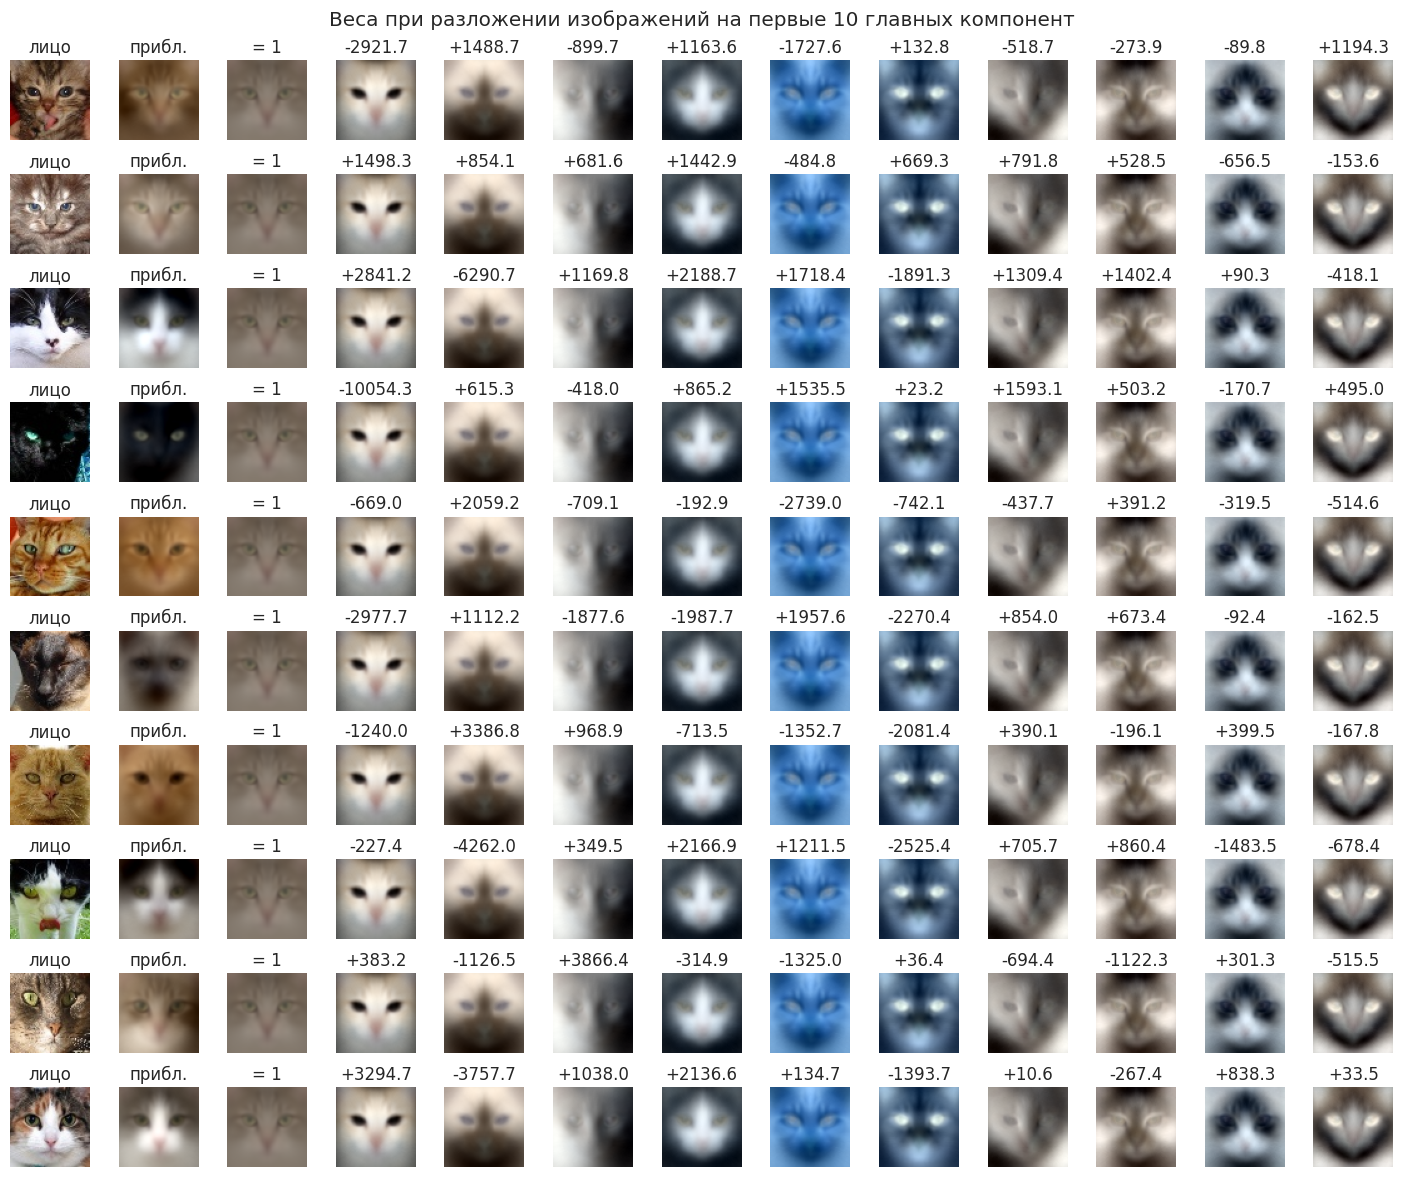

In [19]:
visualize_projection_images(
    cats, n_components=10, num_images=10, image_shape=(64, 64, 3)
)

Также посмотрим на качество восстановленных изображений в зависимости от числа главных компонент.

100%|█████████████████████████████████████████████| 9/9 [10:12<00:00, 68.06s/it]


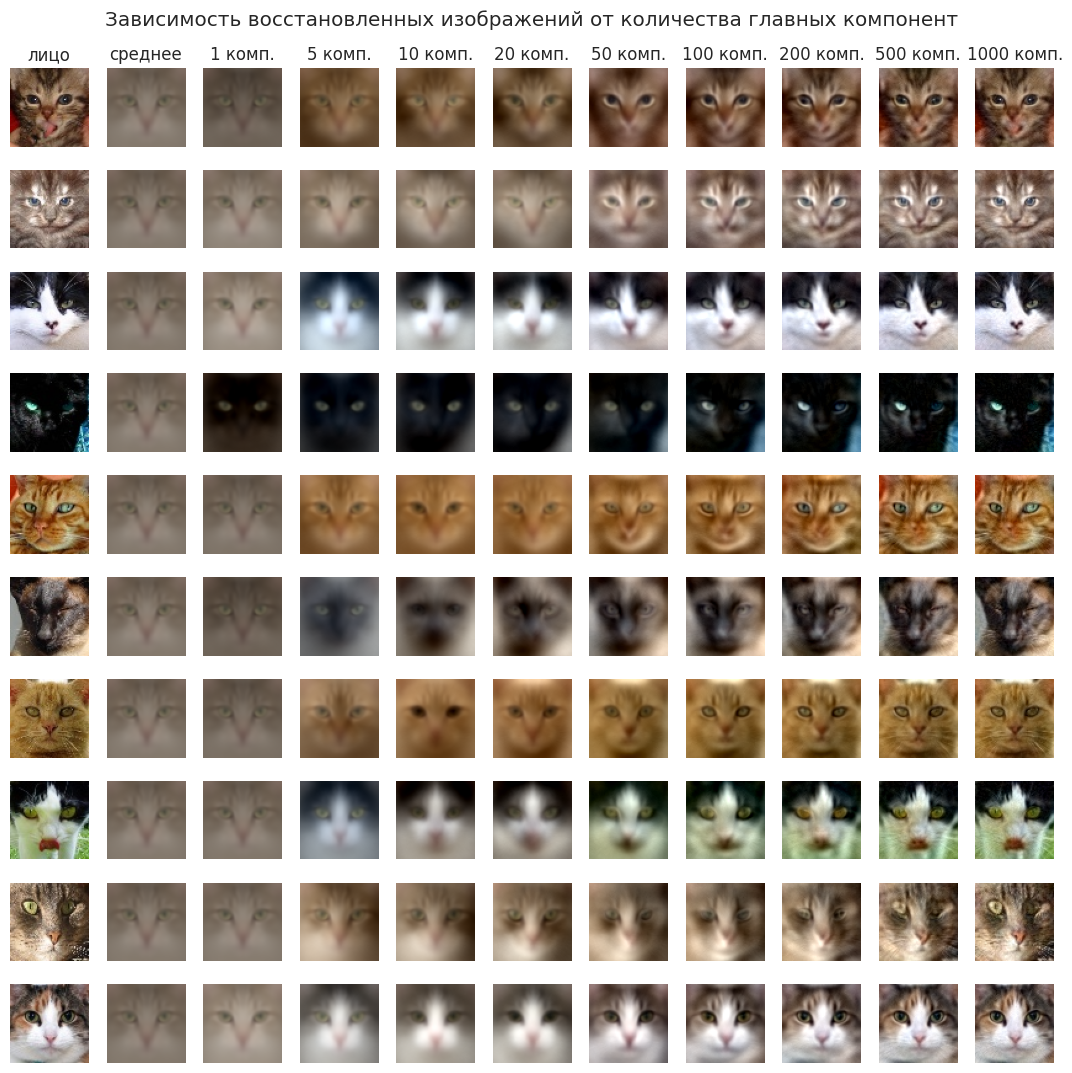

In [20]:
cats_reprojections = visualize_decompress_images(
    cats,
    n_components_grid=[1, 5, 10, 20, 50, 100, 200, 500, 1000],
    num_images=10,
    image_shape=(64, 64, 3),
)

Видим, что уже для 500 главных компонент восстановленные изображения почти не отличаются от оригинальных.

Оценим во сколько раз можно уменьшить размер данного датасета при сжатии в 500-мерное пространство.

Пусть всего $n$ изображений размерности $D$ и делается проекция на $d$ главных компонент, тогда:
- каждое изображение представляется вектором размерности $d$ из `float32`, всего изображений $n$; получаем $4dn$ байт;
- $d$ главных компонент размерности $D$ состоят также из `float32`; получаем $4dD$ байт;
- суммарно выходит $4d \left(D + n\right)$ байт, в то время как исходный датасет занимает $nD$ байт.

Подставив числа для нашего датасета: $n=15747, d=500, D=64 \cdot 64 \cdot 3$ получаем, что исходные картинки весят $185$ МБ, а сжатые картинки $53$ МБ, то есть размер уменьшился в $3.5$ раза.

### 4. Бонус: гифка

Сделаем гифку изменения восстановленного изображения в зависимости от числа главных компонент. Также вместо центрального изображения вставим визуализацию соответствующей главной компоненты

In [21]:
pca = PCA(n_components=1000)
cats_projection = pca.fit_transform(cats.astype(np.float32))

cnt_cats = 9
gif_images = []

image_size = 64
border_size = 2

for num_components in range(1, 1000):
    # Делаем проекцию на первые num_components главных компонент
    projection = (cats[:cnt_cats] - pca.mean_) @ pca.components_[:num_components].T
    # Восстанавливаем спроецированные изображения
    reprojection = projection @ pca.components_[:num_components] + pca.mean_

    # Решейпим вектора в матрицы пикселей
    compressed_images = (
        reprojection.reshape(-1, image_size, image_size, 3)
        .clip(0, 255)
        .astype(np.uint8)
    )

    # Подготавливаем главную компоненту
    pca_component = (
        rescale_image(pca.components_[num_components].reshape(64, 64, 3)) * 255
    ).astype(np.uint8)

    # Собираем коллаж 3х3: в центре текущая num_components-ая главная компонента,
    # по бокам восстановленные изображения
    collage = np.zeros(
        (image_size * 3 + border_size * 2, image_size * 3 + border_size * 2, 3),
        dtype=np.uint8,
    )
    for i, image in enumerate(compressed_images):
        row_begin = (i % 3) * (border_size + image_size)
        col_begin = (i // 3) * (border_size + image_size)

        # Если i == 4, то это центральное изображение, заменяем его на главную компоненту
        if i == 4:
            image = pca_component
        collage[
            row_begin : row_begin + image_size, col_begin : col_begin + image_size
        ] = image

    # Добавляем полученный коллаж в общий массив, перед этим растянув его в два раза
    gif_images.append(
        cv2.resize(
            collage,
            dsize=(collage.shape[0] * 2, collage.shape[0] * 2),
            interpolation=cv2.INTER_CUBIC,
        )
    )

In [22]:
# Для ускорения гифки на большом количестве компонент будем выкидывать часть кадров
frames = gif_images[:50] + gif_images[50:200:3] + gif_images[200::10]
imageio.mimsave("transformation.gif", frames * 5, format="GIF")

Image(url="transformation.gif")